FIFA 21 - EDA (Exploratory Data Analysis)

After the cleaning of the dataset provided with data from FIFA from year 2021, I will carry out an exploratory data analysis. The purpose of this analysis is to answer some questions and gain some insights.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('clean_fifa21_dataset.csv',
				 parse_dates = ['joined', 'loan_date_end', 'on_loan_from',
								   'contract_started', 'contract_ends']
				)

Let's have a look at the variables available, so we can set some questions:

In [3]:
df.columns

Index(['id', 'name', 'longname', 'photo_url', 'player_profile_web',
       'nationality', 'age', 'overall_rating', 'potential_rating', 'club',
       'positions', 'weight_kg', 'preferred_foot', 'best_overall_rating',
       'best_position', 'joined', 'loan_date_end', 'value_million_euros',
       'annual_wage_million_euros', 'release_clause_million_euros',
       'attacking', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'skill', 'dribbling', 'curve',
       'fk_accuracy', 'long_passing', 'ball_control', 'movement',
       'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance',
       'power', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'mentality', 'aggression', 'interceptions', 'positioning', 'vision',
       'penalties', 'composure', 'defending', 'marking', 'standing_tackle',
       'sliding_tackle', 'goalkeeping', 'gk_diving', 'gk_handling',
       'gk_kicking', 'gk_positioning', 'gk_reflexes', 'total_stats',
   

## Some questions to be answered by the dataset

1. How many and who are the players with a contract beyond the end of 2023?  
2. What's the country which has produced the largest number of football players?
3. What's the top 10 most highly paid football players?
4. Who are the top 5 players with the highest release clause?
5. Is there a relationship between age and wage?
6. Do players become unfit as they age?
7. What are the most successful players throwing penalties?
8. What are the top 5 clubs which invest the most on their players salaries? And the least?
9. Are the players who score the most, the most valuable?

In case I want more information about a variable, I will import the dataset dictionary and create a function to retrieve the description of a variable.

In [4]:
descriptions = pd.read_csv('variable_descriptions.csv')

In [5]:
descriptions.set_index('variable', inplace=True)

In [6]:
def get_description(var):
	print(f'Description of "{var}": ', end='---> ')
	print(descriptions.loc[var].values[0])

In [7]:
get_description('penalties')

Description of "penalties": ---> The penalties attribute of the player.


## 1. How many and who are the players with a contract beyond the end of 2023?  

The longest contract has been signed by:

In [8]:
df.nlargest(1,'contract_ends')[['name', 'club', 'contract_started', 'contract_ends']]

,name,club,contract_started,contract_ends
307,Iñaki Williams,Athletic Club de Bilbao,2012-01-01,2028-01-01


In [9]:
players_after_2023 = df[df.contract_ends >= '2024-01-01']

In [10]:
result = players_after_2023.name.count()
print(f'The number of players with a valid contract after the end of this year (as of 2023) is: {result}')

The number of players with a valid contract after the end of this year (as of 2023) is: 2819


The top 5 clubs which make their players sign the longest contracts are...

In [11]:
df.nlargest(5, 'contract_ends')[['name', 'nationality', 'club', 'contract_started', 'contract_ends']]

,name,nationality,club,contract_started,contract_ends
307,Iñaki Williams,Spain,Athletic Club de Bilbao,2012-01-01,2028-01-01
521,P. Estupiñán,Ecuador,Villarreal CF,2020-01-01,2027-01-01
115,Saúl,Spain,Atlético Madrid,2013-01-01,2026-01-01
280,João Félix,Portugal,Atlético Madrid,2019-01-01,2026-01-01
401,Yeray,Spain,Athletic Club de Bilbao,2014-01-01,2026-01-01


## 2. What are the top 10 countries which have produced the largest number of football players?

In [12]:
data = df.groupby('nationality')['id'].count().sort_values(ascending=False)[:10]

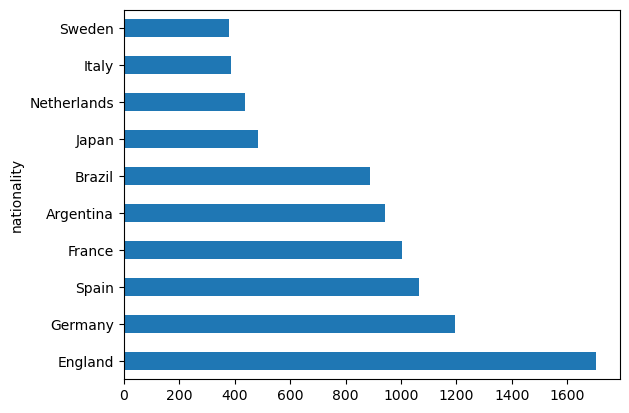

In [13]:
data.plot.barh()
plt.show()

## 3. What's the top 10 most highly paid football players?

In [14]:
data = (df.nlargest(10, 'annual_wage_million_euros')
		[['longname', 'club', 'annual_wage_million_euros']]
		.sort_values('annual_wage_million_euros', ascending=False)
	   )
data = data.rename(columns = {'annual_wage_million_euros' : 'annual_wage_MM_€'})

In [15]:
data

,longname,club,annual_wage_MM_€
0,Lionel Messi,FC Barcelona,29.12
3,Kevin De Bruyne,Manchester City,19.24
15,Karim Benzema,Real Madrid,18.20
26,Eden Hazard,Real Madrid,18.20
12,Carlos Henrique Venancio Casimiro,Real Madrid,16.12
27,Toni Kroos,Real Madrid,16.12
16,Sergio Ramos García,Real Madrid,15.60
17,Sergio Agüero,Manchester City,15.60
28,Antoine Griezmann,FC Barcelona,15.08
4,Neymar da Silva Santos Jr.,Paris Saint-Germain,14.04


## 4. Who are the top 5 players with the highest release clause?

In [16]:
df.nlargest(5, 'release_clause_million_euros')[['longname', 'club', 'release_clause_million_euros']]

,longname,club,release_clause_million_euros
8,Kylian Mbappé,Paris Saint-Germain,203.1
4,Neymar da Silva Santos Jr.,Paris Saint-Germain,166.5
3,Kevin De Bruyne,Manchester City,161.0
2,Jan Oblak,Atlético Madrid,159.4
9,Marc-André ter Stegen,FC Barcelona,147.7


## 5. Is there a relationship between age and wage?

Different players at the same age have different wages. That's why I will take into account the average wage for every age.

### Some insights:  
1. Players, in average, increase their wage as they get older.  
2. The peak values are reached, in average, at ages ranging from 25 to 35.  
3. 35 must be the most common retirement age, as players who remain after that point have lower salaries.  
4. Despite his age, there must be a very well paid player, as we can see at the peak of about 42 years old. 

In [109]:
data = df.groupby('age')['annual_wage_million_euros'].mean()

In [110]:
data.loc[40:]

age
40    0.133872
41    0.104477
42    0.686920
43    0.131300
53    0.003640
Name: annual_wage_million_euros, dtype: float64

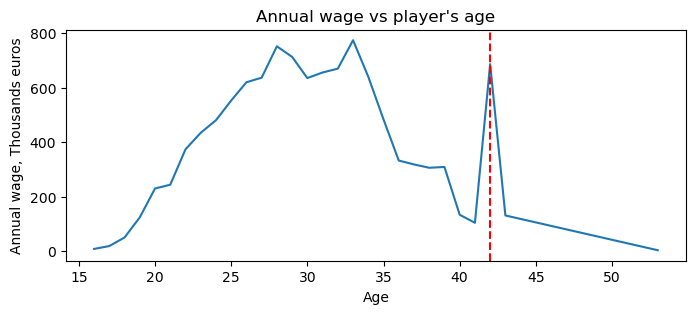

In [111]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(data.index, data.values*1000)
ax.set_title("Annual wage vs player's age")
ax.set_xlabel('Age')
ax.set_ylabel('Annual wage, Thousands euros')
ax.axvline(x=42, ls='dashed', color='red')
plt.show()

### Having seen the graph, I want to go deeper in the aspect of ages:

In [68]:
indexes = df.age.sort_values().nsmallest(1).index[0], df.age.sort_values().nlargest(1).index[0]
data = df.loc[indexes, ['longname', 'age', 'club', 'nationality', 'annual_wage_million_euros']]
data.rename(columns={'annual_wage_million_euros' : 'annual_wage_euros'}, inplace=True)
data.annual_wage_euros = data.annual_wage_euros.apply(lambda x : str( round(x*1000, 2) ) + 'K')

Wages of the youngest and oldest players:

In [69]:
data

,longname,age,club,nationality,annual_wage_euros
17900,Rico Richards,16,West Bromwich Albion,England,52.0K
16109,Kazuyoshi Miura,53,Yokohama FC,Japan,3.64K


Who did correspond to the peak in the graph?

In [73]:
data = df.groupby('age')['annual_wage_million_euros'].mean()

In [77]:
data.loc[40:]

age
40    0.133872
41    0.104477
42    0.686920
43    0.131300
53    0.003640
Name: annual_wage_million_euros, dtype: float64

Definitely there's a peak at the age of 42 years. Let's make an in-depth investigation.

Working out how many players are aged 42. I suspect there will be not many:

In [79]:
df[df.age == 42].id.count()

5

In [87]:
(df[df.age == 42][['longname', 'club', 'positions', 'nationality', 'annual_wage_million_euros']]
	.sort_values('annual_wage_million_euros', ascending=False)
)

,longname,club,positions,nationality,annual_wage_million_euros
262,Gianluigi Buffon,Juventus,['GK'],Italy,2.1320
1083,Vitorino Hilton da Silva,Montpellier HSC,['CB'],Brazil,1.0400
3964,Cristian Lucchetti,Atlético Tucumán,['GK'],Argentina,0.2080
10101,Shunsuke Nakamura,Yokohama FC,"['CAM', 'CF', 'RW']",Japan,0.0520
14779,Luis Fernando Fernández,SD Aucas,['GK'],Colombia,0.0026


### He's the culprit: Gianluigi Buffon, the italian goalkeeper* from Juventus has an outstanding wage despite his age.  
*Remember 'GK' stands for 'goalkeeper'.

## 6. Are older players lower rated?

As done before, I will work out the average rating for different ages.

### Some insights:  
1. The most rated players seem to be aged ranging from 25 to even 40.
2. At the age of 40, on average, they tend to decrease their rating
3. As figured out before, the peak corresponds to Buffon, the italian goalkeeper from Juventus. Currently he's retired, as data from the dataset were obtained in year 2021.

In [112]:
data = df[['age', 'overall_rating']]
data = df.groupby('age').overall_rating.mean()

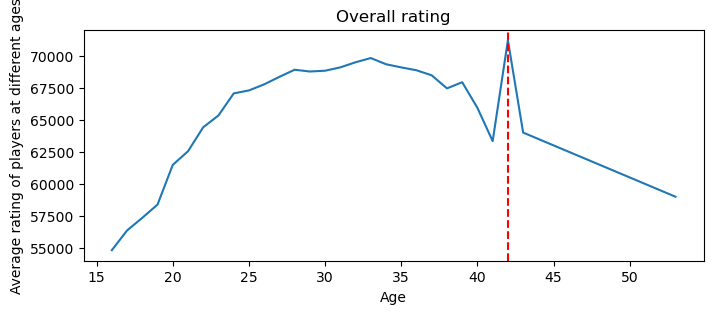

In [114]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(data.index, data.values*1000)
ax.set_title("Overall rating")
ax.set_xlabel('Age')
ax.set_ylabel('Average rating of players at different ages')
ax.axvline(x=42, ls='dashed', color='red')
plt.show()

## 7. What are the most successful players throwing penalties?

In [17]:
df.nlargest(10, 'penalties')[['longname', 'club', 'penalties']]

,longname,club,penalties
4,Neymar da Silva Santos Jr.,Paris Saint-Germain,92
16,Sergio Ramos García,Real Madrid,92
119,Raúl Jiménez,Wolverhampton Wanderers,92
355,Max Kruse,FC Union Berlin,92
1937,Mark Noble,West Ham United,92
34,Bruno Miguel Borges Fernandes,Manchester United,91
98,Marco Reus,Borussia Dortmund,91
172,Luiz Frello Filho Jorge,Chelsea,91
344,Sébastien Haller,West Ham United,91
23,Harry Kane,Tottenham Hotspur,90


## 8. What are the top 5 clubs which invest the most on their players salaries? And the least?

In [18]:
total_wage_per_club = df.groupby('club')['annual_wage_million_euros'].sum()

### Top 5 of clubs with largest total salaries

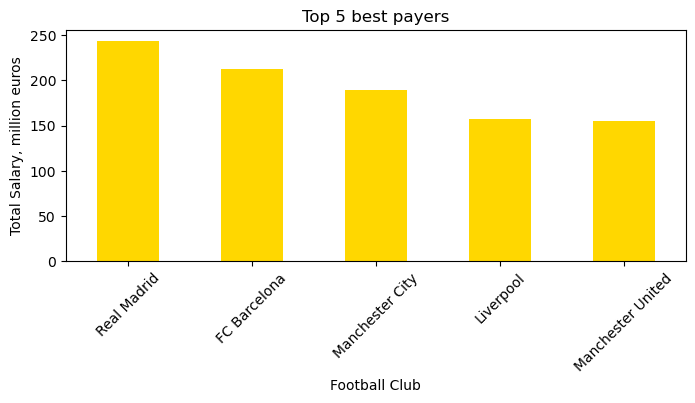

In [98]:
fix, ax = plt.subplots(figsize=(8,3))
total_wage_per_club.nlargest(5).plot.bar(ax = ax, rot=45, color='gold')
ax.set_ylabel('Total Salary, million euros')
ax.set_xlabel('Football Club')
ax.set_title('Top 5 best payers')
plt.show()

If you are interested in colors to be used in `matplotlib`:
[Matplotlib colours](https://matplotlib.org/stable/_images/sphx_glr_colors_004_2_0x.png)  
![Matplotlib colours](https://matplotlib.org/stable/_images/sphx_glr_colors_004_2_0x.png)

### Bottom 5 of clubs with smallest total salaries

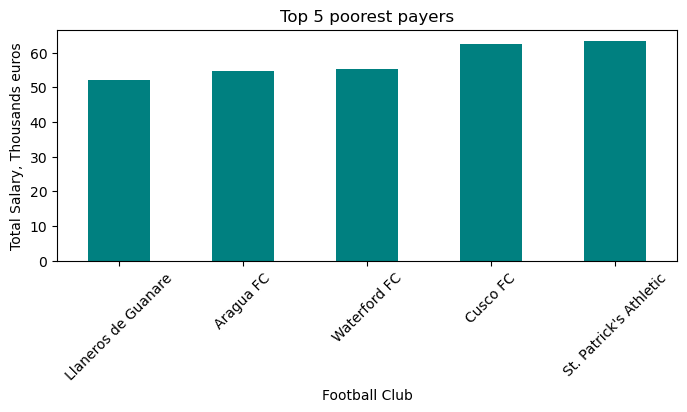

In [100]:
fix, ax = plt.subplots(figsize=(8,3))
data = total_wage_per_club.nsmallest(5) * 1000
data.plot.bar(ax = ax, rot=45, color='teal')
ax.set_ylabel('Total Salary, Thousands euros')
ax.set_xlabel('Football Club')
ax.set_title('Top 5 poorest payers')
plt.show()

## 9. Are players with the most overall rating, the best paid? And the best valued?

### Some insights at the sight of the results:  
1. Only players with a minimum overall rating of 80 start to be well paid.
2. The before mentioned trend is also true regarding to the player's value. Nevertheless, some players, although high skilled, are not so well valued.

In [21]:
player_ratings = df[['overall_rating', 'longname', 'club', 'value_million_euros', 'annual_wage_million_euros']]

In [22]:
rating_wage = player_ratings.groupby('overall_rating')['annual_wage_million_euros'].mean()

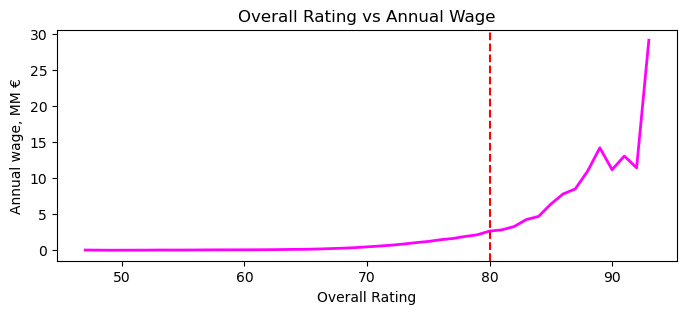

In [101]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(rating_wage.index, rating_wage.values, lw=2, color='magenta')
ax.set_title('Overall Rating vs Annual Wage')
ax.set_xlabel('Overall Rating')
ax.set_ylabel('Annual wage, MM €')
ax.axvline(x=80, ls='dashed', color='red')
plt.show()

In [24]:
rating_value = player_ratings.groupby('overall_rating')['value_million_euros'].mean()

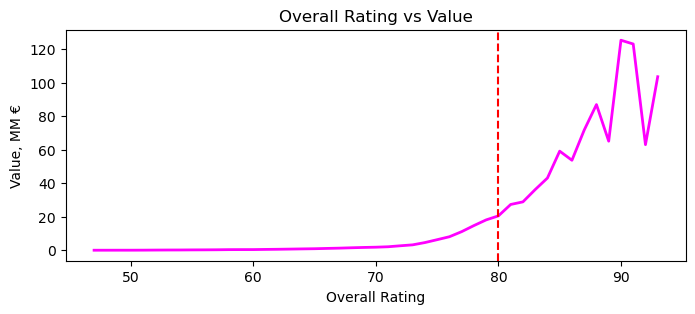

In [102]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(rating_value.index, rating_value.values, lw=2, color='magenta')
ax.set_title('Overall Rating vs Value')
ax.set_xlabel('Overall Rating')
ax.set_ylabel('Value, MM €')
ax.axvline(x=80, ls='dashed', color='red')
plt.show()